# Dimensionality Reduction Results

In [1]:
import pickle
from glob import glob 

from datasets import load_from_disk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from tqdm import tqdm 

from erc.constants import idx2emotion, emotion2idx

sns.set_style("whitegrid")

### Plot Human-rated Valence & Arousal

Execute `python -m fire erc.datasets HF_KEMD --mode=valid --validation_fold=4 --multilabel=False --remove_deuce=True` in advance.

In [2]:
!python -m fire erc.datasets HF_KEMD --mode=valid\
                                     --validation_fold=4\
                                     --multilabel=False\
                                     --remove_deuce=True\
                                     --num_proc=1

INFO:erc.datasets:Load valid Huggingface KEMD Dataset
INFO:erc.datasets:Try Loading dataset kemdy19-kemdy20_valid4_multilabelFalse_rdeuceTrue from disk
INFO:erc.datasets:File not found. Generate hf dataset from scratch
INFO:erc.datasets:Note that if you're running `train.py`, num_proc should be 1, due to unknown deadlocks
INFO:erc.datasets:num_proc given: 1
INFO:erc.datasets:Loading PyTorch dataset.
INFO:erc.datasets:config: {'generate_csv': False, 'return_bio': False, 'tokenizer_name': None, 'max_length_wav': 112000, 'max_length_txt': 64, 'multilabel': False, 'remove_deuce': True, 'validation_fold': 4, 'mode': 'valid', 'num_data': None, 'PRETRAINED_DATA_PATH': './aihub'}
INFO:erc.datasets:kemdy19 dataset has 1888 data
INFO:erc.datasets:Sample data {'segment_id': 'Sess17_script01_F001', 'sampling_rate': 16000, 'wav': tensor([0.0049, 0.0046, 0.0045,  ..., 0.0000, 0.0000, 0.0000]), 'wav_mask': tensor([1, 1, 1,  ..., 0, 0, 0]), 'txt': '뭐야 시간이 이렇게 됐네? 드라마 봐야지. 오빠 불 꺼놓고 거실에서 뭐해?\n', 'txt_ma

In [2]:
ds = load_from_disk("./kemdy19-kemdy20_valid4_multilabelFalse_rdeuceTrue/")

df = pd.DataFrame({
    "emotion": ds["emotion"],
    "valence": ds["valence"],
    "arousal": ds["arousal"],
})
df["emotion"] = df.emotion.apply(idx2emotion.get).values
df.sort_values(by="emotion", key=lambda s: s.apply(emotion2idx.get), inplace=True)

FileNotFoundError: Directory ./kemdy19-kemdy20_valid4_multilabelFalse_rdeuceTrue/ not found

/tmp/ipykernel_480609/175133630.py:8: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.scatterplot(x='arousal', y='valence', data=df,


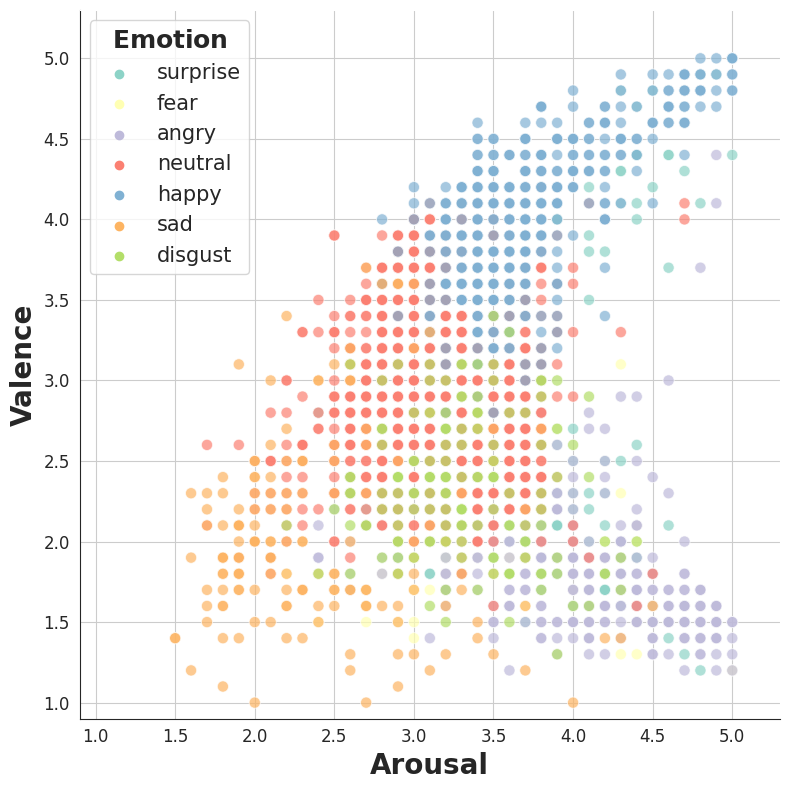

In [9]:
color_palette = sns.color_palette("Set3")
label_fsize = 20
ticks_fsize = 12
legend_size = 15
plt.rcParams["axes.edgecolor"] = "0.15"

_, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='arousal', y='valence', data=df, 
                     hue="emotion",
                     palette=color_palette,
                     s=65, ax=ax,
                         alpha=0.7)
ax.set_xlim((0.9, 5.3))
ax.set_ylim((0.9, 5.3))
ax.legend()

ax.spines['right'].set_color(None)
ax.spines['top'].set_color(None)

plt.rcParams["axes.edgecolor"] = "0.15"
plt.legend(loc='best',
           fontsize=legend_size,title=r'$\bf{Emotion}$',frameon=True,
           fancybox=True,
           title_fontsize=18)
plt.xlabel('Arousal', fontweight='bold', fontsize=label_fsize)
plt.ylabel('Valence', fontweight='bold', fontsize=label_fsize)
plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],size = ticks_fsize)
plt.yticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],size = ticks_fsize)
plt.tight_layout()

# plt.savefig('./etri-eda.svg')
plt.show();

In [ ]:
# load pickle --> RAM 
SAVE_PATH = "./RobertaL_valid_results"

total_emotion = pd.DataFrame()
total_emb = pd.DataFrame()
total_logits = pd.DataFrame()

result_fnames = glob(SAVE_PATH+'/*.pickle')
pbar = tqdm(total=len(result_fnames), 
            iterable=result_fnames)

target_layer = 15
for pickle_name in pbar:
    # load
    with open(pickle_name, 'rb') as f:
        data = pickle.load(f)
    # print(data)
    tmp_emotion = pd.DataFrame(data['emotion'].detach().numpy())
    tmp_linear = pd.DataFrame(data[target_layer].cpu().numpy())
    pred = data[16][:, :-2]
    tmp_pred = pd.DataFrame(pred.argmax(dim=1).cpu().numpy())
    tmp_logits = pd.DataFrame(pred.cpu().numpy())
    
    total_logits = pd.concat(objs=[total_logits, tmp_logits])
    
    total_emotion = pd.concat(objs=[total_emotion,
                                    pd.concat([tmp_emotion, tmp_pred], axis=1)],
                              axis=0)
    total_emb = pd.concat([total_emb, tmp_linear], axis=0)

del tmp_emotion
del tmp_linear

total_emotion.columns = ['emotion', "pred"]

100%|██████████| 585/585 [00:07<00:00, 76.20it/s]


In [36]:
def plot_rd(data: np.ndarray,
            total_emotion: pd.DataFrame,
            correct_only: bool = True,
            incorrect_only: bool = False,
            dim_reduction: str = "pca",
            n_components: int = 2,
            n_sampling: int = 100,
            plot_type: str = "joint",
            title: str = "",
            remove_neutral: bool = False,
            **kwargs):
    
    # Umap config
    if dim_reduction == "umap":
        if not kwargs.get("n_neighbors"):
            kwargs["n_neighbors"] = 15
        if not kwargs.get("min_dist"):
            kwargs["min_dist"] = 0.6

    # Dimensionality Reduction
    if dim_reduction is not None:
        tool = {
            "pca": PCA,
            "tsne": TSNE,
            "umap": UMAP,
        }[dim_reduction](n_components=n_components, **kwargs)
        reduced_data = tool.fit_transform(data)
    else:
        # Pre-transformed data
        reduced_data = data
    # Sample correct
    if correct_only:
        correct_indices = (total_emotion.emotion == total_emotion.pred).values
        reduced_data = reduced_data[correct_indices]
        total_emotion = total_emotion[correct_indices]
    if incorrect_only:
        incorrect_indices = (total_emotion.emotion != total_emotion.pred).values
        reduced_data = reduced_data[incorrect_indices]
        total_emotion = total_emotion[incorrect_indices]

    if n_sampling > 0:
        tmp = pd.DataFrame()
        for emotion in total_emotion.emotion.unique():
            _sub_df = total_emotion[total_emotion.emotion == emotion]
            ns = min(len(_sub_df), n_sampling)
            _sub_df = _sub_df.sample(n=ns)
            tmp = pd.concat([tmp, _sub_df])
        total_emotion = tmp
        
    sns_cmap = sns.color_palette("Set3")
    if remove_neutral:
        reduced_data = reduced_data[total_emotion.emotion != "neutral"]

    total_df = pd.DataFrame(reduced_data)
    total_df.columns = ["dim2", "dim1"]
    total_df["dim1"] = -total_df["dim1"]
    total_df["emotion"] = total_emotion.emotion.apply(idx2emotion.get).values
    total_df.sort_values(by="emotion", inplace=True)
    total_df.sort_values(by="emotion", key=lambda s: s.apply(emotion2idx.get), inplace=True)
    
    total_df["dim1"] = total_df["dim1"] // 0.4
    total_df["dim2"] = total_df["dim2"] // 0.4
    
    fig, ax = plt.subplots(figsize=(8, 8))
    if plot_type == "scatter":
        total_df = total_df.round({"dim1": 1, "dim2": 1})
        sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                        marker='.', alpha=0.85, s=320, palette=sns_cmap, ax=ax)
    elif plot_type == "joint":
        sns.jointplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                      kind="kde", palette=sns_cmap, fill=True, alpha=0.6)
    elif plot_type == "kde":
        sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                    palette=sns_cmap, fill=True, alpha=0.6, ax=ax, levels=2)
    elif plot_type == "kde_scatter":
        sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                    palette=sns_cmap, fill=True, alpha=0.4, ax=ax, gridsize=500)
        sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                        marker='.', alpha=0.7, s=320, palette=sns_cmap, ax=ax)
    
    ax.spines['right'].set_color(None)
    ax.spines['top'].set_color(None)
    ax.get_legend().remove()
    
    ax.set_xlabel(r'$\bf{UMAP_1}$', fontweight='bold', fontsize=label_fsize)
    ax.set_ylabel(r'$\bf{UMAP_2}$', fontweight='bold', fontsize=label_fsize)
    
    fig.tight_layout()

/tmp/ipykernel_480609/4196373659.py:67: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion",


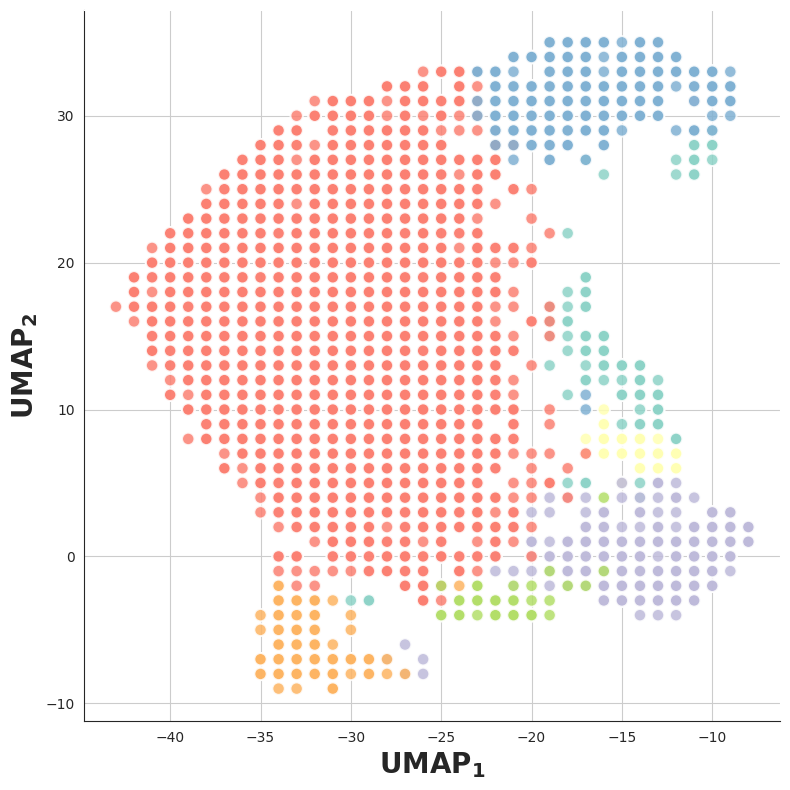

: 

In [37]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        plot_type="scatter",
        n_neighbors=15,
        min_dist=0.6,
        random_state=42)
plt.savefig("./embed.svg")